In [102]:
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import re
import tarfile

from keras.models import Model
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation, Softmax
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, RMSprop
# from keras.activations import softmax
# from keras.utils.data_utils import get_file

## Preprocessing Data

In [103]:
challenges = {
  # QA1 with 10,000 samples
  'single_supporting_fact_10k': 'data/tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
  # QA2 with 10,000 samples
  'two_supporting_facts_10k': 'data/tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
}

In [104]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.

    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

In [105]:
def get_stories(f):
    # data will return a list of triples
    # each triple contains:
    #   1. a story
    #   2. a question about the story
    #   3. the answer to the question
    data = []

    # use this list to keep track of the story so far
    story = []

    # print a random story, helpful to see the data
    printed = False
    for line in f:
        line = line.strip()

        # split the line number from the rest of the line
        nid, line = line.split(' ', 1)

        # see if we should begin a new story
        if int(nid) == 1:
            story = []

        # this line contains a question and answer if it has a tab
        #       question<TAB>answer
        # it also tells us which line in the story is relevant to the answer
        # Note: we actually ignore this fact, since the model will learn
        #       which lines are important
        # Note: the max line number is not the number of lines of the story
        #       since lines with questions do not contain any story
        # one story may contain MULTIPLE questions
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)

            # numbering each line is very useful
            # it's the equivalent of adding a unique token to the front
            # of each sentence
            story_so_far = [[str(i)] + s for i, s in enumerate(story) if s]

            # uncomment if you want to see what a story looks like
            # if not printed and np.random.rand() < 0.5:
            #     print("story_so_far:", story_so_far)
            #     printed = True
            data.append((story_so_far, q, a))
            story.append('')
        else:
            # just add the line to the current story
            story.append(tokenize(line))
    return data

In [106]:
# recursively flatten a list
def should_flatten(el): 
    return not isinstance(el, (str, bytes))

def flatten(l):
    for el in l:
        if should_flatten(el):
            yield from flatten(el)
        else:
            yield el

In [107]:
# convert stories from words into lists of word indexes (integers)
# pad each sequence so that they are the same length
# we will need to re-pad the stories later so that each story
# is the same length
def vectorize_stories(data, word2idx, story_maxlen, query_maxlen):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([[word2idx[w] for w in s] for s in story])
        queries.append([word2idx[w] for w in query])
        answers.append([word2idx[answer]])
    return (
        [pad_sequences(x, maxlen=story_maxlen) for x in inputs],
        pad_sequences(queries, maxlen=query_maxlen),
        np.array(answers)
    )

In [108]:
# this is like 'pad_sequences' but for entire stories
# we are padding each story with zeros so every story
# has the same number of sentences
# append an array of zeros of size:
# (max_sentences - num sentences in story, max words in sentence)
def stack_inputs(inputs, story_maxsents, story_maxlen):
    for i, story in enumerate(inputs):
        inputs[i] = np.concatenate(
            [
                story, 
                np.zeros((story_maxsents - story.shape[0], story_maxlen), 'int')
            ]
        )
    return np.stack(inputs)

In [109]:
def get_file(file_name):
    return open(file_name, 'r')

In [110]:
# make a function to get the data since
# we want to load both the single supporting fact data
# and the two supporting fact data later
def get_data(challenge_type):
    # input should either be 'single_supporting_fact_10k' or 'two_supporting_facts_10k'
    challenge = challenges[challenge_type]


    # returns a list of triples of:
    # (story, question, answer)
    # story is a list of sentences
    # question is a sentence
    # answer is a word
#     train_stories = get_stories(tar.extractfile(challenge.format('train')))
#     test_stories = get_stories(tar.extractfile(challenge.format('test')))
    train_stories = get_stories(get_file(challenge.format('train')))
    test_stories = get_stories(get_file(challenge.format('test')))

    # group all the stories together
    stories = train_stories + test_stories

    # so we can get the max length of each story, of each sentence, and of each question
    story_maxlen = max((len(s) for x, _, _ in stories for s in x))
    story_maxsents = max((len(x) for x, _, _ in stories))
    query_maxlen = max(len(x) for _, x, _ in stories)
    
    print('story_maxlen', story_maxlen)
    print('story_maxsents', story_maxsents)
    print('query_maxlen', query_maxlen)
    
    # Create vocabulary of corpus and find size, including a padding element.
    vocab = sorted(set(flatten(stories)))
    vocab.insert(0, '<PAD>')
    vocab_size = len(vocab)

    # Create an index mapping for the vocabulary.
    word2idx = {c:i for i, c in enumerate(vocab)}

    # convert stories from strings to lists of integers
    inputs_train, queries_train, answers_train = vectorize_stories(
        train_stories, 
        word2idx,
        story_maxlen,
        query_maxlen
      )
  
    inputs_test, queries_test, answers_test = vectorize_stories(
        test_stories, 
        word2idx,
        story_maxlen,
        query_maxlen
      )

    # convert inputs into 3-D numpy arrays
    inputs_train = stack_inputs(inputs_train, story_maxsents, story_maxlen)
    inputs_test = stack_inputs(inputs_test, story_maxsents, story_maxlen)
    print("inputs_train.shape, inputs_test.shape", inputs_train.shape, inputs_test.shape)

    # return model inputs for keras
    return train_stories, test_stories, \
        inputs_train, queries_train, answers_train, \
        inputs_test, queries_test, answers_test, \
        story_maxsents, story_maxlen, query_maxlen, \
        vocab, vocab_size

In [111]:
# get the single supporting fact data
train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size = get_data('single_supporting_fact_10k')

story_maxlen 8
story_maxsents 10
query_maxlen 4
inputs_train.shape, inputs_test.shape (10000, 10, 8) (1000, 10, 8)


## One Supporting Facts Model

### Embedding Layer

In [130]:
embedding_size = 15

In [112]:
# The input story is two dimensional. 
#   The first dimensional is how many sentences
#   The seconde dimensional is how many words
input_story = Input(shape=(story_maxsents, story_maxlen))
print('input_story shape',input_story.shape)
embedded_story = Embedding(vocab_size, embedding_size, name='story_embedding_layer')(input_story)
print('embedded_story shape', embedded_story.shape)
embedded_story = Lambda(lambda x: K.sum(x, axis=2), name='story_lambda_layer')(embedded_story)
print('embedded_story shape after lambda', embedded_story.shape)

input_story shape (?, 10, 8)
embedded_story shape (?, 10, 8, 15)
embedded_story shape after lambda (?, 10, 15)


In [113]:
# The input question is one dimensional since it has only one sentence. 
#   The only dimensional is how many words
input_question = Input(shape=(query_maxlen,))
print('input_question shape',input_question.shape)
embedded_question = Embedding(vocab_size, embedding_size, name='question_embedding_layer')(input_question)
print('embedded_question shape', embedded_question.shape)
embedded_question = Lambda(lambda x: K.sum(x, axis=1), name='question_lambda_layer')(embedded_question)
print('embedded_question shape after lambda', embedded_question.shape)

input_question shape (?, 4)
embedded_question shape (?, 4, 15)
embedded_question shape after lambda (?, 15)


In [114]:
embedded_question = Reshape(target_shape=(1, embedding_size))(embedded_question)
print('embedded_question shape after reshape', embedded_question.shape)

embedded_question shape after reshape (?, 1, 15)


In [115]:
# weights_vec = dot([embedded_story, embedded_question], 2)
# print('weights_vec shape before softmax', weights_vec.shape)
# weights_vec = Softmax(axis=1)(weights_vec)
# print('weights_vec shape after softmax', weights_vec.shape)

x = dot([embedded_story, embedded_question], 2)
x = Reshape((story_maxsents,))(x) # flatten the vector
x = Activation('softmax')(x)
weights_vec = Reshape((story_maxsents, 1))(x) # unflatten it again to be dotted later
print("weights_vec.shape:", weights_vec.shape)

weights_vec.shape: (?, 10, 1)


In [116]:
sent_rel = dot([weights_vec, embedded_story], 1)
print('sent_rel shape after reshape', sent_rel.shape)

sent_rel shape after reshape (?, 1, 15)


In [117]:
x = Reshape((embedding_size,))(sent_rel) # flatten it
ans = Dense(vocab_size, activation='softmax')(x)
print(ans.shape)

(?, 32)
<class 'tensorflow.python.framework.ops.Tensor'>


In [118]:
vocab_size

32

In [120]:
model = Model([input_story, input_question], ans)

model.compile(
  optimizer=RMSprop(lr=1e-2),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 10, 8)        0                                            
__________________________________________________________________________________________________
question_embedding_layer (Embed (None, 4, 15)        480         input_4[0][0]                    
__________________________________________________________________________________________________
story_embedding_layer (Embeddin (None, 10, 8, 15)    480         input_3[0][0]                    
__________________________________________________________________________________________________
question_l

In [121]:
# train the model
r = model.fit(
  [inputs_train, queries_train],
  answers_train,
  epochs=4,
  batch_size=32,
  validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/4
10000/10000 [==============================] - 2s 204us/step - loss: 0.6628 - acc: 0.7752 - val_loss: 0.0327 - val_acc: 0.9920
Epoch 2/4
10000/10000 [==============================] - 2s 196us/step - loss: 0.0088 - acc: 0.9969 - val_loss: 2.3994e-04 - val_acc: 1.0000
Epoch 3/4
10000/10000 [==============================] - 1s 144us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0321 - val_acc: 0.9910
Epoch 4/4
10000/10000 [==============================] - 1s 128us/step - loss: 0.0047 - acc: 0.9992 - val_loss: 3.9439e-06 - val_acc: 1.0000


In [123]:
print(answers_train)
print(answers_train.shape)

[[19]
 [22]
 [22]
 ...
 [22]
 [25]
 [27]]
(10000, 1)


In [128]:

# Check how we weight each input sentence given a story and question
debug_model = Model([input_story, input_question], weights_vec)

# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
inputs_test = inputs_train[story_idx:story_idx+1]
query_test = queries_train[story_idx:story_idx+1]
weights = debug_model.predict([inputs_test, query_test]).flatten()

story, question, ans = train_stories[story_idx]
print("story:\n")
for i, line in enumerate(story):
    print("{:1.5f}".format(weights[i]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)

story:

0.00000 	 0 Mary went to the garden .
0.00980 	 1 Sandra journeyed to the bedroom .
0.00000 	 3 Mary journeyed to the bathroom .
0.98963 	 4 Sandra travelled to the garden .
0.00003 	 6 Daniel travelled to the kitchen .
0.00054 	 7 John travelled to the bathroom .
question: Where is Sandra ?
answer: garden


## Two Supporting Facts Model

### Load data

In [158]:
# get the two supporting fact data
train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size = get_data('two_supporting_facts_10k')

story_maxlen 8
story_maxsents 88
query_maxlen 5
inputs_train.shape, inputs_test.shape (10000, 88, 8) (1000, 88, 8)


### Embedding Layer

In [294]:
embedding_size = 30

In [295]:
input_story = Input(shape=(story_maxsents, story_maxlen))
input_question = Input(shape=(query_maxlen,))

embedding_story = Embedding(vocab_size, embedding_size, name='story_embedding_all')
embedding_story_lambda = Lambda(lambda x: K.sum(x, axis=2), name='story_embedding_lambda_all')

In [296]:
def story_embedding(input_story):
    embedding = Embedding(vocab_size, embedding_size)(input_story)
    embedding = Lambda(lambda x: K.sum(x, axis=2))(embedding)
    return embedding

In [297]:
def question_embedding(input_question):
    embedding = Embedding(vocab_size, embedding_size)(input_question)
    embedding = Lambda(lambda x: K.sum(x, axis=1))(embedding)
    return embedding

In [298]:
def hop(story, question):
    
    x = Reshape((1, embedding_size))(question)
    x = dot([story, x], 2)
    x = Reshape((story_maxsents,))(x) # flatten the vector
    x = Activation('softmax')(x)
    weights_vec = Reshape((story_maxsents, 1))(x) # unflatten it again to be dotted later
    
#     story_embedding2 = story_embedding(input_story)
    story_embedding2 = embedding_story(input_story)
    story_embedding2 = embedding_story_lambda(story_embedding2)
    
    sent_rel = dot([weights_vec, story_embedding2], 1)
    x = Reshape((embedding_size,))(sent_rel) # flatten it
    x = dense_layer(x)
    return x, story_embedding2, weights_vec

In [299]:
# embedded_story = story_embedding(input_story)

embedded_story = embedding_story(input_story)
embedded_story = embedding_story_lambda(embedded_story)

embedded_question = question_embedding(input_question)
embedded_question = Reshape(target_shape=(1, embedding_size))(embedded_question)

dense_layer = Dense(embedding_size, activation='elu')

story_state1, embedded_story1, _ = hop(embedded_story, embedded_question)
story_state2, _, _ = hop(embedded_story1, story_state1)

ans = Dense(vocab_size, activation='softmax')(story_state2)

In [300]:
model = Model([input_story, input_question], ans)

model.compile(
  optimizer=RMSprop(lr=5e-3),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 5, 30)        3720        input_44[0][0]                   
__________________________________________________________________________________________________
input_43 (InputLayer)           (None, 88, 8)        0                                            
__________________________________________________________________________________________________
lambda_27 (Lambda)              (None, 30)           0           embedding_27[0][0]               
__________________________________________________________________________________________________
story_embe

In [301]:
r = model.fit(
  [inputs_train, queries_train],
  answers_train,
  epochs=30,
  batch_size=32,
  validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/30
10000/10000 [==============================] - 15s 1ms/step - loss: 1.8644 - acc: 0.1699 - val_loss: 1.7876 - val_acc: 0.1830
Epoch 2/30
10000/10000 [==============================] - 12s 1ms/step - loss: 1.6641 - acc: 0.3039 - val_loss: 1.5336 - val_acc: 0.3690
Epoch 3/30
10000/10000 [==============================] - 11s 1ms/step - loss: 1.5108 - acc: 0.3759 - val_loss: 1.5573 - val_acc: 0.3530
Epoch 4/30
10000/10000 [==============================] - 16s 2ms/step - loss: 1.0844 - acc: 0.5875 - val_loss: 0.7047 - val_acc: 0.7620
Epoch 5/30
10000/10000 [==============================] - 12s 1ms/step - loss: 0.6969 - acc: 0.7526 - val_loss: 0.7538 - val_acc: 0.7320
Epoch 6/30
10000/10000 [==============================] - 13s 1ms/step - loss: 0.6147 - acc: 0.7819 - val_loss: 0.6941 - val_acc: 0.7530
Epoch 7/30
10000/10000 [==============================] - 12s 1ms/step - loss: 0.5632 - acc: 0.8053 - val_loss: 0.6345 - val_acc:

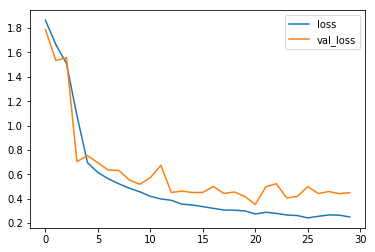

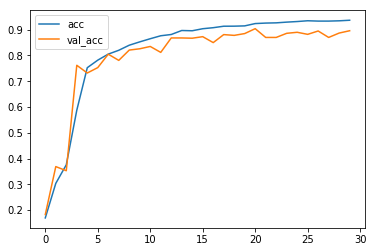

In [302]:
### plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

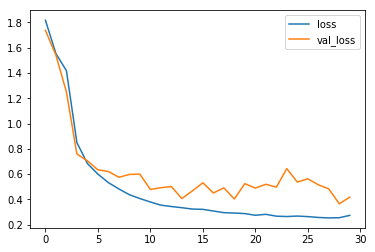

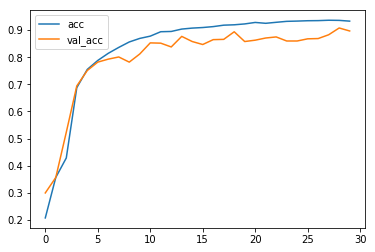

In [276]:
### plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()